# Download, parse, extract Ontario human IAV from NCBI Influenza DB

- Download all nucleotide sequences in the NCBI Influenza DB 
- Parse Human HA gene sequences from Ontario beloning to H1 or H3
- Group sequences by subtype and flu season
- Perform multiple sequence alignments (MSA)


In [70]:
import re
from pathlib import Path

import pandas as pd
import numpy as np

from Bio import SeqIO
from Bio import Entrez

Email is required to use NCBI Entrez API

In [13]:
Entrez.email = 'peter.kruczkiewicz@canada.ca'

Downloaded all Influenza nucleotide sequences from the NCBI FTP site for the NCBI Influenza DB (2019-09-26T08:51:00+5):

```bash
wget ftp://ftp.ncbi.nih.gov/genomes/INFLUENZA/influenza.fna.gz
```

Output FASTA headers for H1 or H3 HA genes (`(segment 4|\(HA\)|hemagglutinin)`) Influenza A from Ontario (`(Ontario|Toronto|Canada-ON)`) to `ontario-H1-H3-HA-gene-seg4-or-HA.txt`

```bash
zcat influenza.fna.gz | grep -P "^>.*A.*/(Ontario|Toronto|Canada-ON)/.*\(H(1|3)N\w\).*(segment 4|\(HA\)|hemagglutinin)" > ontario-H1-H3-HA-gene-seg4-or-HA.txt
```

Extract GI/NCBI ID from FASTA headers with regex

In [15]:
header = '>gi|52078172|gb|AY619969|Influenza A virus (A/swine/Ontario/K01477/01(H3N3)) hemagglutinin (HA) gene, complete cds'

Check that the number after `>gi|` can be parsed

In [16]:
REGEX_GI = re.compile(r'>gi\|(\d+)')
m = REGEX_GI.match(header)
if m:
    print(m.group(1))

52078172


Parse all GIs

In [17]:
gis = []
with open('ontario-H1-H3-HA-gene-seg4-or-HA.txt') as f:
    for l in f:
        m = REGEX_GI.match(l)
        if m:
            gis.append(m.group(1))

Should have 892 unique GIs

In [73]:
assert len(set(gis)) == len(gis)
len(gis)

892

Fetch Genbank entries for each of the 892 GI/NCBI IDs 

In [19]:
with Entrez.efetch(db='nucleotide',
                   id=gis,
                   rettype='gb',
                   retmode='text') as efetch_handle:
    entrez_gb_recs = [x for x in SeqIO.parse(efetch_handle, 'genbank')]

Should have retrieved 892 Genbank records

In [20]:
len(entrez_gb_recs)

892

Peek into one of the Genbank entries

In [21]:
gb_rec = entrez_gb_recs[0]

In [23]:
gb_rec

SeqRecord(seq=Seq('ATGAAGACCATTATTGTTCTGAGTTGTTTTTTCTGTCTGGCTTTCAGCCAAAAT...TGA', IUPACAmbiguousDNA()), id='AY619969.1', name='AY619969', description='Influenza A virus (A/swine/Ontario/K01477/01(H3N3)) hemagglutinin (HA) gene, complete cds', dbxrefs=[])

In [25]:
gb_rec.name

'AY619969'

In [24]:
gb_rec.description

'Influenza A virus (A/swine/Ontario/K01477/01(H3N3)) hemagglutinin (HA) gene, complete cds'

In [22]:
gb_rec.annotations

{'molecule_type': 'RNA',
 'topology': 'linear',
 'data_file_division': 'VRL',
 'date': '28-DEC-2004',
 'accessions': ['AY619969'],
 'sequence_version': 1,
 'keywords': [''],
 'source': 'Influenza A virus (A/swine/Ontario/K01477/01(H3N3))',
 'organism': 'Influenza A virus (A/swine/Ontario/K01477/01(H3N3))',
 'taxonomy': ['Viruses',
  'ssRNA viruses',
  'ssRNA negative-strand viruses',
  'Orthomyxoviridae',
  'Influenzavirus A'],
 'references': [Reference(title='Characterization of avian H3N3 and H1N1 influenza A viruses isolated from pigs in Canada', ...),
  Reference(title='Direct Submission', ...)]}

In [27]:
gb_rec.features

[SeqFeature(FeatureLocation(ExactPosition(0), ExactPosition(1701), strand=1), type='source'),
 SeqFeature(FeatureLocation(ExactPosition(0), ExactPosition(1701), strand=1), type='gene'),
 SeqFeature(FeatureLocation(ExactPosition(0), ExactPosition(1701), strand=1), type='CDS')]

In [74]:
gb_rec.features[0].qualifiers

OrderedDict([('organism',
              ['Influenza A virus (A/swine/Ontario/K01477/01(H3N3))']),
             ('mol_type', ['genomic RNA']),
             ('strain', ['A/swine/Ontario/K01477/01']),
             ('serotype', ['H3N3']),
             ('db_xref', ['taxon:292589'])])

Check that all Genbank records have a source feature as the first sequence feature

In [28]:
all([x.features[0].type == 'source' for x in entrez_gb_recs])

True

Parse metadata from Genbank source sequence feature qualifiers

In [29]:
def parse_gb_md(rec):
    source_feature = rec.features[0]
    assert source_feature.type == 'source', rec
    return {k:v[0] for k,v in rec.features[0].qualifiers.items()}

In [32]:
def genbank_md(rec): 
    out = parse_gb_md(rec)
    out['accession'] = rec.id
    return out

Convert list of metadata dicts to Pandas DataFrame

In [33]:
df_gb_md_892 = pd.DataFrame([genbank_md(x) for x in entrez_gb_recs])

Parse/coerce `collection_date` values into standard DateTime format (`pd.Timestamp`)

In [43]:
dates = pd.to_datetime(df_gb_md_892.collection_date, errors='coerce')
years = [x.year if not pd.isnull(x) else None for x in dates]
df_gb_md_892['collection_year'] = years
df_gb_md_892.collection_date = [str(x).split()[0] if not pd.isnull(x) else None for x in dates]

Set values for collection year, month and day in DataFrame

In [45]:
df_gb_md_892['collection_month'] = dates.dt.month
df_gb_md_892['collection_day'] = dates.dt.day

In [51]:
dts = pd.to_datetime(df_gb_md_892.collection_date)

### Compute flu season

Come up with a function to output flu season value where the collection date is used to derive the flu season based on the following:

- if month is August (8) or less, then flu season is `{year - 1}-{year}`
- otherwise, flu season is `{year}-{year + 1}`

For example,
- a collection date of 2018-05-01 should have a flu season of 2017-2018
- a collection date of 2016-10-01 should have a flu season of 2016-2017

In [53]:
dt = dts.loc[891]

In [54]:
dt

Timestamp('2018-05-01 00:00:00')

In [57]:
dt.month

5

In [58]:
def flu_season(dt):
    m = dt.month
    y = dt.year
    return f'{y}-{y+1}' if m > 8 else f'{y-1}-{y}'

In [59]:
flu_season(dt)

'2017-2018'

Add flu season for each non-null collection date in the dataframe

In [60]:
flu_seasons = [flu_season(dt) if not pd.isnull(dt) else None for dt in dts]

In [62]:
df_gb_md_892['flu_season'] = flu_seasons

Sort by collection date in descending order (most recent to least)

In [64]:
df_gb_md_892.sort_values('collection_date', inplace=True, ascending=False)

Peek at DataFrame of sequence metadata

In [65]:
df_gb_md_892

,organism,mol_type,strain,serotype,db_xref,accession,country,host,segment,collection_date,isolation_source,isolate,note,lab_host,lat_lon,collection_year,collection_month,collection_day,flu_season
891,Influenza A virus,viral cRNA,A/swine/Ontario/SD0298/2018,H3N2,taxon:11320,MK462790.1,Canada: Ontario,swine,4,2018-05-01,MDCK cells,NaN,NaN,NaN,NaN,2018.0,5.0,1.0,2017-2018
744,Influenza A virus,viral cRNA,A/Ontario/026/2018,H3N2,taxon:11320,MG889769.1,Canada: Ontario,Homo sapiens,4,2018-01-11,nasopharyngeal swab,026,original specimen,NaN,NaN,2018.0,1.0,11.0,2017-2018
752,Influenza A virus,viral cRNA,A/Ontario/034/2018,H3N2,taxon:11320,MG889777.1,Canada: Ontario,Homo sapiens,4,2018-01-11,nasopharyngeal swab,034,original specimen,NaN,NaN,2018.0,1.0,11.0,2017-2018
751,Influenza A virus,viral cRNA,A/Ontario/033/2018,H3N2,taxon:11320,MG889776.1,Canada: Ontario,Homo sapiens,4,2018-01-11,nasopharyngeal swab,033,original specimen,NaN,NaN,2018.0,1.0,11.0,2017-2018
754,Influenza A virus,viral cRNA,A/Ontario/038/2018,H3N2,taxon:11320,MG889779.1,Canada: Ontario,Homo sapiens,4,2018-01-10,nasopharyngeal swab,038,original specimen,NaN,NaN,2018.0,1.0,10.0,2017-2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,Influenza A virus (A/Ontario/RV1273/2005(H3N2)),genomic DNA,A/Ontario/RV1273/2005,H3N2,taxon:381529,DQ469962.1,Canada,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
12,Influenza A virus (A/swine/Ontario/33853/2005(...,genomic DNA,A/swine/Ontario/33853/2005,H3N2,taxon:381533,DQ469994.1,Canada,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
13,Influenza A virus (A/turkey/Ontario/31232/2005...,genomic DNA,A/turkey/Ontario/31232/2005,H3N2,taxon:381534,DQ470002.1,Canada,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
14,Influenza A virus (A/swine/Ontario/00130/97(H3...,genomic RNA,A/swine/Ontario/00130/97,NaN,taxon:133777,AF251395.2,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None


### Save entire dataframe to CSV file

In [66]:
df_gb_md_892.to_csv('2019-09-26-McLaughlin-NCBI-Influenza-DB-H3-or-H1-Ontario-metadata-from-genbank.csv', index=False)

### Filter for human-derived samples

Frequencies of distinct host values

In [67]:
df_gb_md_892.host.value_counts()

Homo sapiens                       698
swine                               27
turkey                              10
human; gender M; age 25              6
Swine                                6
                                  ... 
Homo sapiens; gender M; age 84Y      1
Homo sapiens; gender M; age 9Y       1
human; gender M; age 0               1
Homo sapiens; gender F; age 28Y      1
human; gender M; age 55              1
Name: host, Length: 109, dtype: int64

IAV with host info not provided in GenBank file source feature

In [69]:
df_gb_md_892[pd.isnull(df_gb_md_892.host)]

,organism,mol_type,strain,serotype,db_xref,accession,country,host,segment,collection_date,isolation_source,isolate,note,lab_host,lat_lon,collection_year,collection_month,collection_day,flu_season
0,Influenza A virus (A/swine/Ontario/K01477/01(H...,genomic RNA,A/swine/Ontario/K01477/01,H3N3,taxon:292589,AY619969.1,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
1,Influenza A virus (A/swine/Ontario/42729A/01(H...,genomic RNA,A/swine/Ontario/42729A/01,H3N3,taxon:292590,AY619977.1,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
2,Influenza A virus (A/swine/Ontario/Biovet1/05(...,genomic RNA,A/swine/Ontario/Biovet1/05,H3N2,taxon:354557,DQ241762.1,Canada,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
3,Influenza A virus (A/swine/Ontario/57561/03(H1...,genomic RNA,A/swine/Ontario/57561/03,H1N1,taxon:358575,DQ280195.1,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
4,Influenza A virus (A/swine/Ontario/55383/04(H1...,genomic RNA,A/swine/Ontario/55383/04,H1N2,taxon:358580,DQ280212.1,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
5,Influenza A virus (A/swine/Ontario/53518/03(H1...,genomic RNA,A/swine/Ontario/53518/03,H1N1,taxon:358577,DQ280219.1,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
6,Influenza A virus (A/swine/Ontario/52156/03(H1...,genomic RNA,A/swine/Ontario/52156/03,H1N2,taxon:358581,DQ280227.1,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
7,Influenza A virus (A/swine/Ontario/48235/04(H1...,genomic RNA,A/swine/Ontario/48235/04,H1N2,taxon:358582,DQ280236.1,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
8,Influenza A virus (A/swine/Ontario/23866/04(H1...,genomic RNA,A/swine/Ontario/23866/04,H1N1,taxon:358578,DQ280243.1,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
9,Influenza A virus (A/swine/Ontario/11112/2004(...,genomic RNA,A/swine/Ontario/11112/04,H1N1,taxon:358579,DQ280250.1,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None


In [76]:
human_regex_pattern = r'.*([Hh]uman|[Hh]omo).*'

In [77]:
df_gb_md_892.host.str.match(human_regex_pattern).sum()

828

What does the metadata for the non-human regex pattern matching sequences look like?

In [85]:
for i,r in df_gb_md_892[~df_gb_md_892.host.str.match(human_regex_pattern, na=False)].iterrows():
    print(f'{r.strain: <40} {r.host: <20} {r.collection_date}')

A/swine/Ontario/SD0298/2018              swine                2018-05-01
A/swine/Ontario/DM_21/2017               swine                2017-04-26
A/swine/Ontario/DM_11/2017               swine                2017-01-16
A/turkey/Ontario/FAV-006-4/2016          turkey               2016-04-07
A/turkey/Ontario/FAV-006-10/2016         turkey               2016-04-07
A/turkey/Ontario/FAV-005-2/2016          turkey               2016-04-05
A/swine/Ontario/G3/2014                  swine                2014-11-07
A/swine/Ontario/G10/2014                 swine                2014-09-04
A/swine/Ontario/G12/2014                 swine                2014-09-03
A/swine/Ontario/G13/2014                 swine                2014-09-03
A/swine/Ontario/G14/2014                 swine                2014-08-12
A/swine/Ontario/G16/2014                 swine                2014-07-24
A/swine/Ontario/G11/2014                 swine                2014-07-15
A/swine/Ontario/G15/2014                 swine     

In [86]:
df_human = df_gb_md_892[df_gb_md_892.host.str.match(human_regex_pattern, na=False)]

In [93]:
df_human.host.value_counts().to_dict()

{'Homo sapiens': 698,
 'human; gender M; age 25': 6,
 'Homo sapiens; gender F; age 22': 4,
 'Homo sapiens; gender M; age 21Y': 3,
 'Homo sapiens; gender M; age 26Y': 3,
 'human; gender F; age 39': 2,
 'human; gender F; age 25': 2,
 'Homo sapiens; gender M; age 83Y': 2,
 'human; gender F; age 14': 2,
 'human; gender M; age 17': 2,
 'Homo sapiens; gender M; age 79Y': 2,
 'Homo sapiens; gender M; age 95Y': 2,
 'human; gender F; age 33': 2,
 'Homo sapiens; gender M; age 86Y': 2,
 'human; gender F; age 5': 2,
 'Homo sapiens; gender M; age 73Y': 2,
 'Homo sapiens; gender M; age 76Y': 2,
 'human; gender F; age 24': 2,
 'Homo sapiens; gender F; age 91Y': 2,
 'Homo sapiens; gender M; age 2Y': 2,
 'Homo sapiens; gender M; age 4Y': 2,
 'Homo sapiens; gender M; age 19Y': 1,
 'human; gender M; age 5': 1,
 'Homo sapiens; gender M; age 32Y': 1,
 'Homo sapiens; gender M; age 11mo': 1,
 'human; gender M; age 14': 1,
 'human; gender F; age 88': 1,
 'Homo sapiens; gender F; age 21Y': 1,
 'human; gender M

In [94]:
df_human.to_csv('2019-09-26-McLaughlin-NCBI-Influenza-DB-H3-or-H1-Ontario-Human-metadata-from-genbank.csv', index=False)

## Write all Genbank records to a file

In [36]:
SeqIO.write(entrez_gb_recs, '2019-09-26-McLaughlin-NCBI-Influenza-DB-H3-or-H1-Ontario-metadata-from-genbank.gb', 'genbank')

892

## Partition human sequences by flu season

In [103]:
id_to_gb = {x.id:x for x in entrez_gb_recs}

In [95]:
df_human.flu_season.value_counts()

2015-2016    210
2016-2017    163
2014-2015    135
2010-2011     67
2012-2013     57
2009-2010     54
2017-2018     50
2008-2009     40
2011-2012     30
2013-2014     16
2007-2008      6
Name: flu_season, dtype: int64

Group by `flu_season` and `serotype`

In [110]:
g = df_human.groupby(['flu_season','serotype'])

Create lists of accessions grouped by `flu_season` and `serotype`

In [111]:
grouped_acc = g.accession.apply(list)

In [112]:
grouped_acc

flu_season  serotype
2007-2008   H1N1        [FJ800811.1, FJ800819.1, FJ800810.1, FJ800818....
2008-2009   H1N1        [HQ239567.1, CY060534.2, CY060502.2, CY060526....
2009-2010   H1N1        [CY081093.2, HQ239460.2, CY060726.2, HQ239459....
            H3N2                     [JQ658889.1, JQ658888.1, CY054550.1]
2010-2011   H1N1        [CY081101.2, CY081069.2, CY081085.2, CY081077....
            H3N2        [CY111003.1, CY111002.1, CY111001.1, CY111000....
2011-2012   H1N1        [JX875001.1, KF551079.1, KF551095.1, KF551093....
            H3N2        [KF551077.1, KF551078.1, KF551076.1, KF551075....
2012-2013   H1N1        [KF886379.1, KF886366.1, KF886376.1, KF886371....
            H3N2        [KJ734749.1, KF886354.1, KJ734748.1, KJ734747....
2013-2014   H1N1        [KP864399.1, KP864397.1, KP864398.1, KP864396....
            H3N2                     [KP864423.1, KP864424.1, KP864425.1]
2014-2015   H3N2        [KU729355.1, KU729354.1, KU729353.1, KU729458....
2015-2016   H1N1 

### Write partitioned human HA sequences to GenBank and FASTA files

In [109]:
!mkdir human-HA-sequences-by-flu-season

In [117]:
for (flu_season, serotype), accessions in grouped_acc.items():
    print(f'{serotype}| Flu season: {flu_season} (N={len(accessions)})')
    gbs = [id_to_gb[acc] for acc in accessions]
    filename = f'human-HA-sequences-by-flu-season/HA-{serotype}-flu_season-{flu_season}'
    SeqIO.write(gbs, f'{filename}.gb', 'genbank')
    SeqIO.write(gbs, f'{filename}.fa', 'fasta')

H1N1| Flu season: 2007-2008 (N=6)
H1N1| Flu season: 2008-2009 (N=40)
H1N1| Flu season: 2009-2010 (N=51)
H3N2| Flu season: 2009-2010 (N=3)
H1N1| Flu season: 2010-2011 (N=5)
H3N2| Flu season: 2010-2011 (N=62)
H1N1| Flu season: 2011-2012 (N=18)
H3N2| Flu season: 2011-2012 (N=12)
H1N1| Flu season: 2012-2013 (N=18)
H3N2| Flu season: 2012-2013 (N=39)
H1N1| Flu season: 2013-2014 (N=13)
H3N2| Flu season: 2013-2014 (N=3)
H3N2| Flu season: 2014-2015 (N=135)
H1N1| Flu season: 2015-2016 (N=198)
H3N2| Flu season: 2015-2016 (N=12)
H1N1| Flu season: 2016-2017 (N=1)
H3N2| Flu season: 2016-2017 (N=162)
H3N2| Flu season: 2017-2018 (N=50)


Peek into output directory at `human-HA-sequences-by-flu-season/`

In [118]:
!ls -lh human-HA-sequences-by-flu-season/

total 5.4M
-rw-r--r-- 1 pkruczkiewicz grp_pkruczkiewicz 5.7K Sep 26 11:43 HA-H1N1-flu_season-2007-2008.fa
-rw-r--r-- 1 pkruczkiewicz grp_pkruczkiewicz  21K Sep 26 11:43 HA-H1N1-flu_season-2007-2008.gb
-rw-r--r-- 1 pkruczkiewicz grp_pkruczkiewicz  67K Sep 26 11:43 HA-H1N1-flu_season-2008-2009.fa
-rw-r--r-- 1 pkruczkiewicz grp_pkruczkiewicz 206K Sep 26 11:43 HA-H1N1-flu_season-2008-2009.gb
-rw-r--r-- 1 pkruczkiewicz grp_pkruczkiewicz  91K Sep 26 11:43 HA-H1N1-flu_season-2009-2010.fa
-rw-r--r-- 1 pkruczkiewicz grp_pkruczkiewicz 279K Sep 26 11:43 HA-H1N1-flu_season-2009-2010.gb
-rw-r--r-- 1 pkruczkiewicz grp_pkruczkiewicz 9.2K Sep 26 11:43 HA-H1N1-flu_season-2010-2011.fa
-rw-r--r-- 1 pkruczkiewicz grp_pkruczkiewicz  27K Sep 26 11:43 HA-H1N1-flu_season-2010-2011.gb
-rw-r--r-- 1 pkruczkiewicz grp_pkruczkiewicz  33K Sep 26 11:43 HA-H1N1-flu_season-2011-2012.fa
-rw-r--r-- 1 pkruczkiewicz grp_pkruczkiewicz 103K Sep 26 11:43 HA-H1N1-flu_season-2011-2012.gb
-rw-r--r-- 1 pkruczkiewicz grp_pkruczki

# MAFFT multiple sequence alignment (MSA) of partitioned human HA genes

Perform MSA with MAFFT (v7.407) of each set of sequences with the L-INS-i strategy for high accuracy. 

In [119]:
!mafft --version

v7.407 (2018/Jul/23)


In [121]:
!mafft --help

------------------------------------------------------------------------------
  MAFFT v7.407 (2018/Jul/23)
  https://mafft.cbrc.jp/alignment/software/
  MBE 30:772-780 (2013), NAR 30:3059-3066 (2002)
------------------------------------------------------------------------------
High speed:
  % mafft in > out
  % mafft --retree 1 in > out (fast)

High accuracy (for <~200 sequences x <~2,000 aa/nt):
  % mafft --maxiterate 1000 --localpair  in > out (% linsi in > out is also ok)
  % mafft --maxiterate 1000 --genafpair  in > out (% einsi in > out)
  % mafft --maxiterate 1000 --globalpair in > out (% ginsi in > out)

If unsure which option to use:
  % mafft --auto in > out

--op # :         Gap opening penalty, default: 1.53
--ep # :         Offset (works like gap extension penalty), default: 0.0
--maxiterate # : Maximum number of iterative refinement, default: 0
--clustalout :   Output: clustal format, default: fasta
--reorder :      Outorder: aligned, default: input order
--quiet :      

In [120]:
!mkdir human-HA-sequences-by-flu-season/mafft-msa

Use GNU Parallel to run parallel instances of `mafft` MSA

In [123]:
!parallel -v mafft --thread -1 --maxiterate 1000 --localpair {} ">" human-HA-sequences-by-flu-season/mafft-msa/{/} ::: human-HA-sequences-by-flu-season/*.fa

mafft --thread -1 --maxiterate 1000 --localpair human-HA-sequences-by-flu-season/HA-H1N1-flu_season-2016-2017.fa > human-HA-sequences-by-flu-season/mafft-msa/HA-H1N1-flu_season-2016-2017.fa
OS = linux
The number of physical cores =  28
outputhat23=16
treein = 0
compacttree = 0
minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
randomseed = 0
blosum 62 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16

Strategy:
 L-INS-i (Probably most accurate, very slow)
 Iterative refinement method (<16) with LOCAL pairwise alignment information

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has been changed in version 7.110 (2013 Oct).
It tends to insert more gaps into gap-rich regions than previous versions.
To disable this change, add the --leavegappyregion option.

mafft --thread -1 --maxiterate 1000 --localpair human-HA-sequences-by-flu

mafft --thread -1 --maxiterate 1000 --localpair human-HA-sequences-by-flu-season/HA-H1N1-flu_season-2013-2014.fa > human-HA-sequences-by-flu-season/mafft-msa/HA-H1N1-flu_season-2013-2014.fa
OS = linux
The number of physical cores =  28
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
generating a scoring matrix for nucleotide (dist=200) ... done
All-to-all alignment.
tbfast-pair (nuc) Version 7.407
alg=L, model=DNA200 (2), 2.00 (6.00), -0.10 (-0.30), noshift, amax=0.0
28 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
generating a scoring matrix for nucleotide (dist=200) ... done
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 13
done.

Progressive alignment ... 
STEP    12 /12 (thread   11) 
done.
tbfast (nuc) Version 7.407
alg=A, model=DNA200 (2), 1.53 (4.59), -0.00 (-0.00), noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
ra

mafft --thread -1 --maxiterate 1000 --localpair human-HA-sequences-by-flu-season/HA-H3N2-flu_season-2012-2013.fa > human-HA-sequences-by-flu-season/mafft-msa/HA-H3N2-flu_season-2012-2013.fa
OS = linux
The number of physical cores =  28
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
generating a scoring matrix for nucleotide (dist=200) ... done
All-to-all alignment.
tbfast-pair (nuc) Version 7.407
alg=L, model=DNA200 (2), 2.00 (6.00), -0.10 (-0.30), noshift, amax=0.0
28 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
generating a scoring matrix for nucleotide (dist=200) ... done
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   30 / 39
done.

Progressive alignment ... 
STEP    38 /38 (thread    9) 
done.
tbfast (nuc) Version 7.407
alg=A, model=DNA200 (2), 1.53 (4.59), -0.00 (-0.00), noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
ra

mafft --thread -1 --maxiterate 1000 --localpair human-HA-sequences-by-flu-season/HA-H1N1-flu_season-2015-2016.fa > human-HA-sequences-by-flu-season/mafft-msa/HA-H1N1-flu_season-2015-2016.fa
OS = linux
The number of physical cores =  28
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
generating a scoring matrix for nucleotide (dist=200) ... done
All-to-all alignment.
tbfast-pair (nuc) Version 7.407
alg=L, model=DNA200 (2), 2.00 (6.00), -0.10 (-0.30), noshift, amax=0.0
28 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
generating a scoring matrix for nucleotide (dist=200) ... done
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
  190 / 198
done.

Progressive alignment ... 
STEP   132 /197 (thread    7) 
Reallocating (by thread 15) ..done. *alloclen = 3096
STEP   197 /197 (thread    7) 
done.
tbfast (nuc) Version 7.407
alg=A, model=DNA200 (2), 1.53 (4.59), -0.00 (-0.00), noshift, amax

mafft --thread -1 --maxiterate 1000 --localpair human-HA-sequences-by-flu-season/HA-H3N2-flu_season-2014-2015.fa > human-HA-sequences-by-flu-season/mafft-msa/HA-H3N2-flu_season-2014-2015.fa
OS = linux
The number of physical cores =  28
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
generating a scoring matrix for nucleotide (dist=200) ... done
All-to-all alignment.
tbfast-pair (nuc) Version 7.407
alg=L, model=DNA200 (2), 2.00 (6.00), -0.10 (-0.30), noshift, amax=0.0
28 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
generating a scoring matrix for nucleotide (dist=200) ... done
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
  130 / 135
done.

Progressive alignment ... 
STEP   134 /134 (thread    7) 
done.
tbfast (nuc) Version 7.407
alg=A, model=DNA200 (2), 1.53 (4.59), -0.00 (-0.00), noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8


mafft --thread -1 --maxiterate 1000 --localpair human-HA-sequences-by-flu-season/HA-H3N2-flu_season-2016-2017.fa > human-HA-sequences-by-flu-season/mafft-msa/HA-H3N2-flu_season-2016-2017.fa
OS = linux
The number of physical cores =  28
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
generating a scoring matrix for nucleotide (dist=200) ... done
All-to-all alignment.
tbfast-pair (nuc) Version 7.407
alg=L, model=DNA200 (2), 2.00 (6.00), -0.10 (-0.30), noshift, amax=0.0
28 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
generating a scoring matrix for nucleotide (dist=200) ... done
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
  160 / 162
done.

Progressive alignment ... 
STEP   161 /161 (thread   14) 
done.
tbfast (nuc) Version 7.407
alg=A, model=DNA200 (2), 1.53 (4.59), -0.00 (-0.00), noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8


In [124]:
!mkdir human-HA-sequences-by-flu-season/concat

In [125]:
!cat human-HA-sequences-by-flu-season/HA-H1N1*.fa > human-HA-sequences-by-flu-season/concat/HA-H1N1-all-seasons.fa
!cat human-HA-sequences-by-flu-season/HA-H3N2*.fa > human-HA-sequences-by-flu-season/concat/HA-H3N2-all-seasons.fa

In [126]:
!mkdir human-HA-sequences-by-flu-season/concat/mafft-msa

In [127]:
!parallel -v mafft --thread -1 --maxiterate 1000 --localpair {} ">" human-HA-sequences-by-flu-season/concat/mafft-msa/{/} ::: human-HA-sequences-by-flu-season/concat/*.fa

mafft --thread -1 --maxiterate 1000 --localpair human-HA-sequences-by-flu-season/concat/HA-H1N1-all-seasons.fa > human-HA-sequences-by-flu-season/concat/mafft-msa/HA-H1N1-all-seasons.fa
OS = linux
The number of physical cores =  28
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
generating a scoring matrix for nucleotide (dist=200) ... done
All-to-all alignment.
tbfast-pair (nuc) Version 7.407
alg=L, model=DNA200 (2), 2.00 (6.00), -0.10 (-0.30), noshift, amax=0.0
28 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
generating a scoring matrix for nucleotide (dist=200) ... done
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
  340 / 350
done.

Progressive alignment ... 
STEP   342 /349 (thread    8) 
Reallocating (by thread 6) ..done. *alloclen = 4548
STEP   349 /349 (thread   14) 
done.
tbfast (nuc) Version 7.407
alg=A, model=DNA200 (2), 1.53 (4.59), -0.00 (-0.00), noshift, amax=0.0


mafft --thread -1 --maxiterate 1000 --localpair human-HA-sequences-by-flu-season/concat/HA-H3N2-all-seasons.fa > human-HA-sequences-by-flu-season/concat/mafft-msa/HA-H3N2-all-seasons.fa
OS = linux
The number of physical cores =  28
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
generating a scoring matrix for nucleotide (dist=200) ... done
All-to-all alignment.
tbfast-pair (nuc) Version 7.407
alg=L, model=DNA200 (2), 2.00 (6.00), -0.10 (-0.30), noshift, amax=0.0
28 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
generating a scoring matrix for nucleotide (dist=200) ... done
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
  470 / 478
done.

Progressive alignment ... 
STEP   477 /477 (thread    7) 
done.
tbfast (nuc) Version 7.407
alg=A, model=DNA200 (2), 1.53 (4.59), -0.00 (-0.00), noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
rand

## Data Visualization



In [ ]:
pd.set_option()

In [128]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/CSCScience.ca/pkruczkiewicz/miniconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [209]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", context="paper")

In [30]:
import matplotlib.style as mplstyle
mplstyle.use(['seaborn', 'seaborn-talk', 'fast'])

In [130]:
df_human['sequence_length'] = [len(id_to_gb[x]) for x in df_human.accession]

/home/CSCScience.ca/pkruczkiewicz/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Distribution of sequence lengths

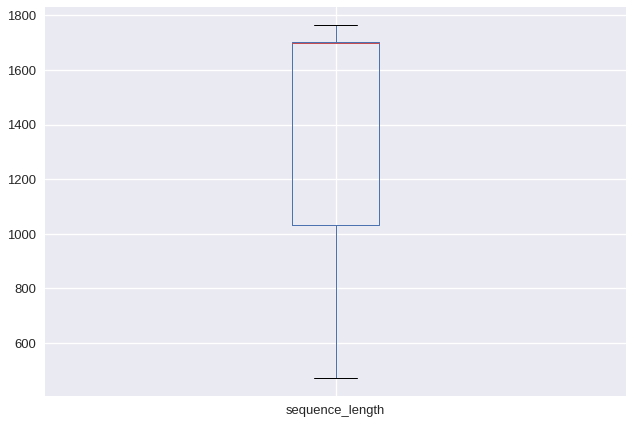

In [213]:
fig = df_human.boxplot(column='sequence_length')

In [171]:
fig.figure.savefig('figures/boxplots-sequence_length.svg', bbox_inches='tight')

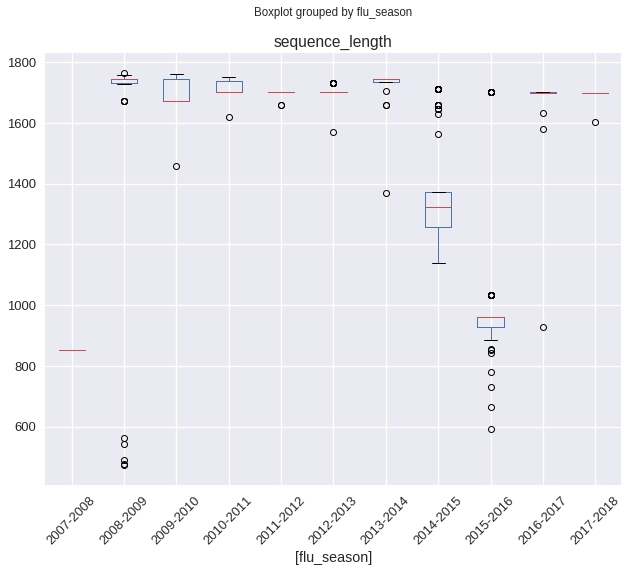

In [214]:
fig = df_human.boxplot(column='sequence_length', 
                       by=['flu_season'], 
                       figsize=(10,8), 
                       rot=45,)

In [169]:
fig.figure.savefig('figures/boxplots-sequence_length-by-flu_season.svg', bbox_inches='tight')

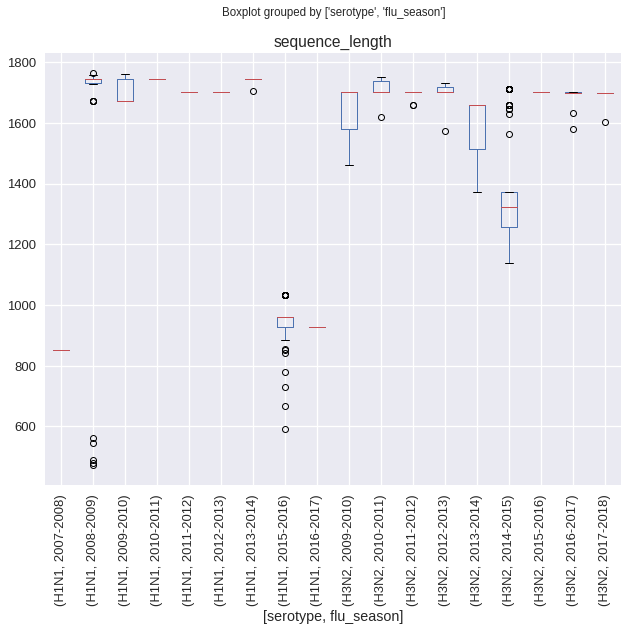

In [216]:
fig = df_human.boxplot(column='sequence_length', 
                       by=['serotype', 'flu_season'], 
                       figsize=(10,8), 
                       rot=90,)

In [222]:
df_human_dt = df_human.copy()
df_human_dt.collection_date = pd.to_datetime(df_human_dt.collection_date)

### Sequence length at different time points

- H1N1 HA gene sequences much more variable with many shorter sequences deposited esp. in 2015-2016

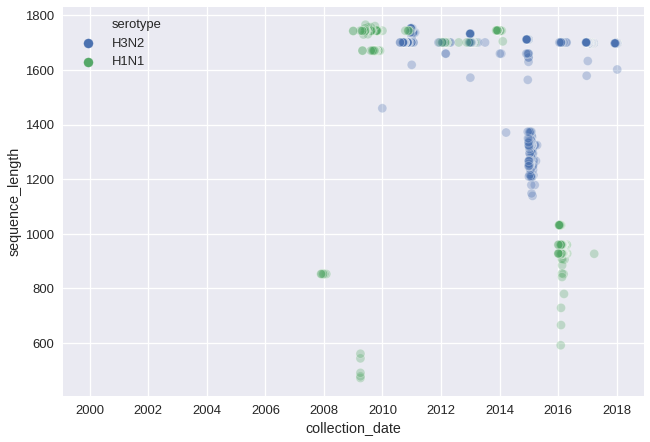

In [224]:
sns.scatterplot('collection_date', 
                'sequence_length', 
                hue='serotype', 
                data=df_human_dt,
                alpha=0.3)

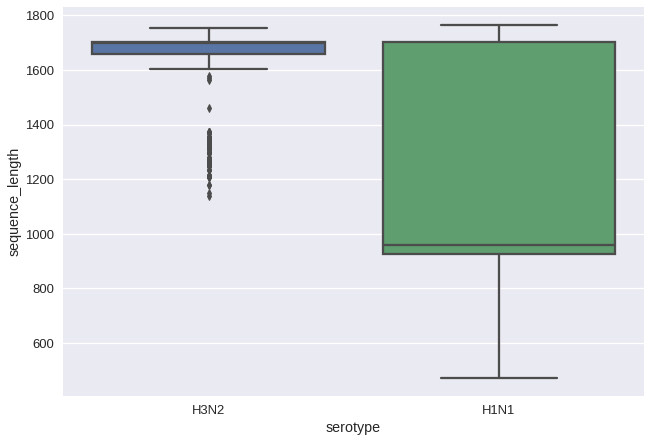

In [219]:
sns.boxplot(x='serotype', y='sequence_length', data=df_human)

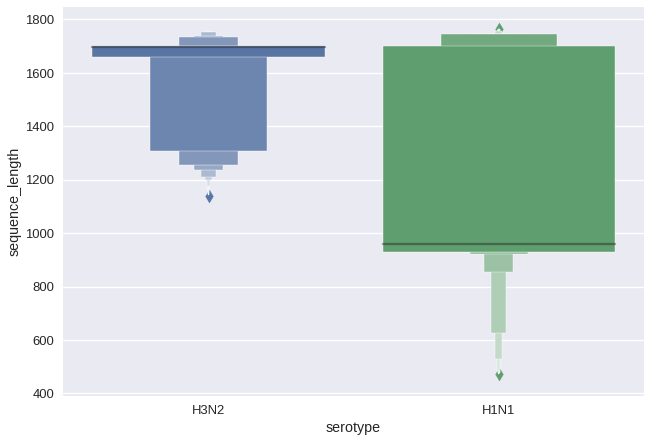

In [218]:
sns.boxenplot(x='serotype', y='sequence_length', data=df_human)

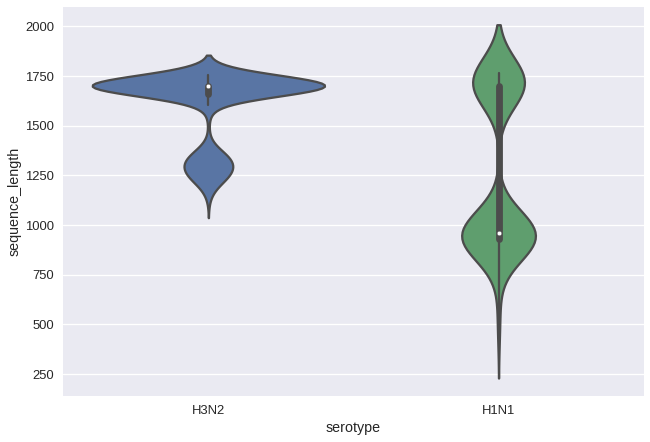

In [234]:
sns.violinplot(x='serotype', y='sequence_length', data=df_human)

## Visualizing multiple sequence alignment (MSA)

Especially interested in regions where there is nearly 100% coverage by all sequences.

In [2]:
import re
from pathlib import Path
from Bio import SeqIO, AlignIO
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
subtype_msapath = {re.sub(r'HA-(H\dN\d)-.*', r'\1', x.name): x for x in Path.cwd().glob('**/concat/mafft-msa/*.fa')}

In [5]:
subtype_msapath

{'H3N2': PosixPath('/home/CSCScience.ca/pkruczkiewicz/projects/2019-09-23-IAV-McLaughlin-project/human-HA-sequences-by-flu-season/concat/mafft-msa/HA-H3N2-all-seasons.fa'),
 'H1N1': PosixPath('/home/CSCScience.ca/pkruczkiewicz/projects/2019-09-23-IAV-McLaughlin-project/human-HA-sequences-by-flu-season/concat/mafft-msa/HA-H1N1-all-seasons.fa')}

In [6]:
headers = []
seq_arrays = []
with open(subtype_msapath['H1N1']) as fh:
    for header, seq in SeqIO.FastaIO.SimpleFastaParser(fh):
        headers.append(header)
        seq_array = np.array(list(bytes(seq.upper(), 'utf8')))
        seq_arrays.append(seq_array)

In [7]:
len(headers)

350

In [8]:
msa_array = np.array(seq_arrays)

In [55]:
msa_non_dash_positions = msa_array.shape[0] - np.apply_along_axis(lambda x: (x==45).sum(), 0, msa_array)

### MSA coverage barplot

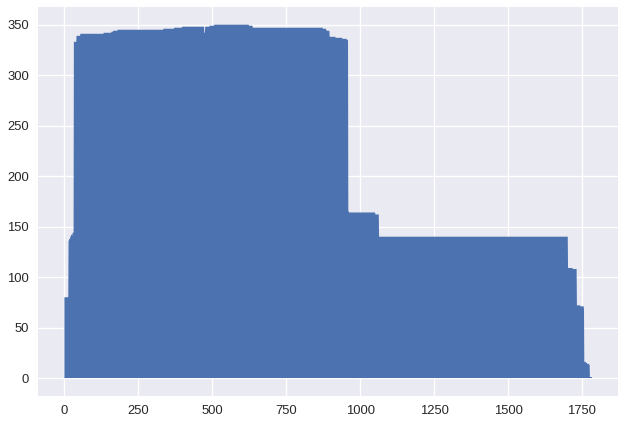

In [56]:
plt.fill_between(range(msa_non_dash_positions.size), msa_non_dash_positions)

### Visualization of MSA nucleotides

- Different colours for different nucleotides
- White for missing sequence

In [70]:
mplstyle.use(['seaborn-ticks'])

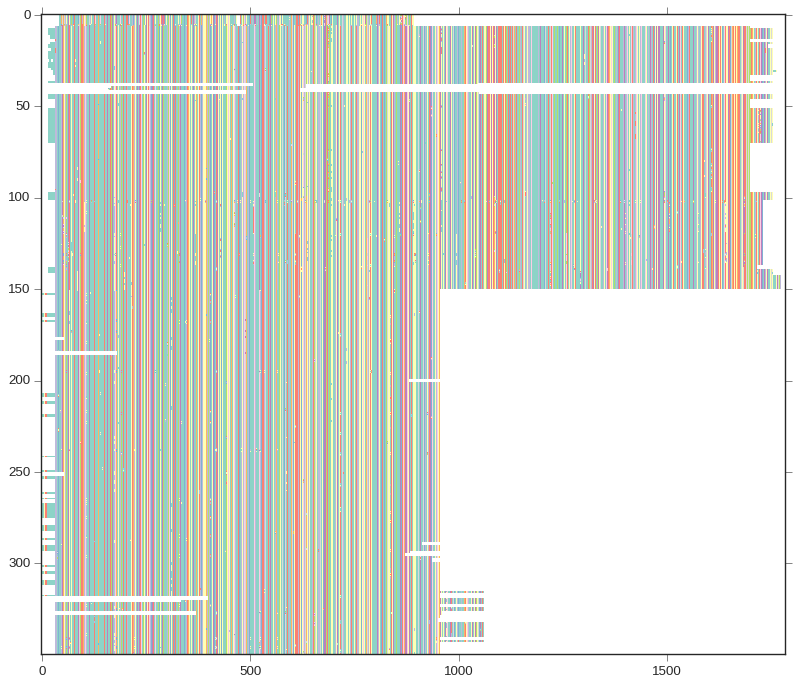

In [75]:
fig = plt.figure(figsize=(12,10))
plt.imshow(msa_array_null, cmap='Set3', aspect='auto', )

In [76]:
fig.savefig('msa-h1n1.svg')

# Maximum-likelihood phylogenetic tree inference with IQ-TREE

In [77]:
!iqtree

IQ-TREE multicore version 1.6.12 for Linux 64-bit built Aug 15 2019
Developed by Bui Quang Minh, Nguyen Lam Tung, Olga Chernomor,
Heiko Schmidt, Dominik Schrempf, Michael Woodhams.

Command-line examples (replace 'iqtree ...' by actual path to executable):

1. Infer maximum-likelihood tree from a sequence alignment (example.phy)
   with the best-fit model automatically selected by ModelFinder:
     iqtree -s example.phy

2. Perform ModelFinder without subsequent tree inference:
     iqtree -s example.phy -m MF
   (use '-m TEST' to resemble jModelTest/ProtTest)

3. Combine ModelFinder, tree search, ultrafast bootstrap and SH-aLRT test:
     iqtree -s example.phy -alrt 1000 -bb 1000

4. Perform edge-linked proportional partition model (example.nex):
     iqtree -s example.phy -spp example.nex
   (replace '-spp' by '-sp' for edge-unlinked model)

5. Find best partition scheme by possibly merging partitions:
     iqtree -s example.phy -sp example.nex -m MF+MERGE
   (use '-m TESTMERGEONLY' 

In [78]:
!iqtree -h

IQ-TREE multicore version 1.6.12 for Linux 64-bit built Aug 15 2019
Developed by Bui Quang Minh, Nguyen Lam Tung, Olga Chernomor,
Heiko Schmidt, Dominik Schrempf, Michael Woodhams.

Usage: iqtree -s <alignment> [OPTIONS]

GENERAL OPTIONS:
  -? or -h             Print this help dialog
  -version             Display version number
  -s <alignment>       Input alignment in PHYLIP/FASTA/NEXUS/CLUSTAL/MSF format
  -st <data_type>      BIN, DNA, AA, NT2AA, CODON, MORPH (default: auto-detect)
  -q <partition_file>  Edge-linked partition model (file in NEXUS/RAxML format)
 -spp <partition_file> Like -q option but allowing partition-specific rates
  -sp <partition_file> Edge-unlinked partition model (like -M option of RAxML)
  -t <start_tree_file> or -t BIONJ or -t RANDOM
                       Starting tree (default: 99 parsimony tree and BIONJ)
  -te <user_tree_file> Like -t but fixing user tree (no tree search performed)
  -o <outgroup_taxon>  Outgroup taxon name for writing .treefile
  -pre

In [82]:
msa_h1n1 = subtype_msapath['H1N1']

In [85]:
!iqtree -s $msa_h1n1 -bb 1000 -m MFP -nt 16

IQ-TREE multicore version 1.6.12 for Linux 64-bit built Aug 15 2019
Developed by Bui Quang Minh, Nguyen Lam Tung, Olga Chernomor,
Heiko Schmidt, Dominik Schrempf, Michael Woodhams.

Host:    beauty (AVX2, FMA3, 251 GB RAM)
Command: iqtree -s /home/CSCScience.ca/pkruczkiewicz/projects/2019-09-23-IAV-McLaughlin-project/human-HA-sequences-by-flu-season/concat/mafft-msa/HA-H1N1-all-seasons.fa -bb 1000 -m MFP -nt 16
Seed:    620087 (Using SPRNG - Scalable Parallel Random Number Generator)
Time:    Fri Sep 27 10:35:34 2019
Kernel:  AVX+FMA - 16 threads (56 CPU cores detected)

Reading alignment file /home/CSCScience.ca/pkruczkiewicz/projects/2019-09-23-IAV-McLaughlin-project/human-HA-sequences-by-flu-season/concat/mafft-msa/HA-H1N1-all-seasons.fa ... Fasta format detected
Alignment most likely contains DNA/RNA sequences
Alignment has 350 sequences with 1785 columns, 546 distinct patterns
365 parsimony-informative, 148 singleton sites, 1272 constant sites
            Gap/Ambiguity  Compositio


For your convenience alignment with unique sequences printed to /home/CSCScience.ca/pkruczkiewicz/projects/2019-09-23-IAV-McLaughlin-project/human-HA-sequences-by-flu-season/concat/mafft-msa/HA-H1N1-all-seasons.fa.uniqueseq.phy


Create initial parsimony tree by phylogenetic likelihood library (PLL)... 0.049 seconds
NOTE: ModelFinder requires 51 MB RAM!
ModelFinder will test 286 DNA models (sample size: 1785) ...
 No. Model         -LnL         df  AIC          AICc         BIC
  1  JC            7604.612     545 16299.225    16779.564    19289.735
  2  JC+I          7523.047     546 16138.094    16620.585    19134.090
  3  JC+G4         7508.283     546 16108.566    16591.057    19104.563
  4  JC+I+G4       7509.489     547 16112.979    16597.629    19114.463
  5  JC+R2         7504.093     547 16102.186    16586.836    19103.670
  6  JC+R3         7503.513     549 16105.026    16594.014    19117.485
 14  F81+F         7525.189     548 16146.377    16633.193    19153.348
 15  F81+F+I

 84  K3P+R3        7132.379     551 15366.758    15860.110    18390.190
 92  K3Pu+F        7160.326     550 15420.652    15911.819    18438.597
 93  K3Pu+F+I      7062.285     551 15226.570    15719.922    18250.002
 94  K3Pu+F+G4     7051.497     551 15204.994    15698.347    18228.427
 95  K3Pu+F+I+G4   7051.515     552 15207.030    15702.575    18235.949
 96  K3Pu+F+R2     7052.772     552 15209.545    15705.090    18238.465
 97  K3Pu+F+R3     7052.521     554 15213.043    15712.994    18252.937
105  TPM2+F        7157.381     550 15414.762    15905.929    18432.707
106  TPM2+F+I      7061.691     551 15225.382    15718.735    18248.815
107  TPM2+F+G4     7049.810     551 15201.620    15694.973    18225.053
108  TPM2+F+I+G4   7050.069     552 15204.137    15699.683    18233.057
109  TPM2+F+R2     7050.172     552 15204.344    15699.890    18233.264
110  TPM2+F+R3     7049.915     554 15207.830    15707.782    18247.725
118  TPM2u+F       7157.397     550 15414.794    15905.961    18

185  TIM2e+G4      7124.530     549 15347.060    15836.048    18359.518
186  TIM2e+I+G4    7125.218     550 15350.435    15841.602    18368.381
187  TIM2e+R2      7121.994     550 15343.988    15835.155    18361.934
188  TIM2e+R3      7121.476     552 15346.952    15842.498    18375.872
196  TIM2+F        7156.886     551 15415.772    15909.125    18439.204
197  TIM2+F+I      7060.884     552 15225.768    15721.314    18254.688
198  TIM2+F+G4     7048.963     552 15201.925    15697.471    18230.845
199  TIM2+F+I+G4   7049.178     553 15204.357    15702.101    18238.764
200  TIM2+F+R2     7049.173     553 15204.345    15702.090    18238.752
201  TIM2+F+R3     7048.936     555 15207.871    15710.036    18253.253
209  TIM3e         7241.250     548 15578.499    16065.315    18585.470
210  TIM3e+I       7148.116     549 15394.232    15883.219    18406.690
211  TIM3e+G4      7133.937     549 15365.875    15854.862    18378.333
212  TIM3e+I+G4    7134.326     550 15368.653    15859.820    18

279  GTR+F+R3      7046.160     557 15206.320    15712.931    18262.675
Akaike Information Criterion:           TVM+F+G4
Corrected Akaike Information Criterion: TPM2+F+G4
Bayesian Information Criterion:         HKY+F+G4
Best-fit model: HKY+F+G4 chosen according to BIC

All model information printed to /home/CSCScience.ca/pkruczkiewicz/projects/2019-09-23-IAV-McLaughlin-project/human-HA-sequences-by-flu-season/concat/mafft-msa/HA-H1N1-all-seasons.fa.model.gz
CPU time for ModelFinder: 322.116 seconds (0h:5m:22s)
Wall-clock time for ModelFinder: 21.952 seconds (0h:0m:21s)
Generating 1000 samples for ultrafast bootstrap (seed: 620087)...

NOTE: 21 MB RAM (0 GB) is required!
Estimate model parameters (epsilon = 0.100)
1. Initial log-likelihood: -7456.844
2. Current log-likelihood: -7061.954
3. Current log-likelihood: -7053.813
4. Current log-likelihood: -7053.384
Optimal log-likelihood: -7053.346
Rate parameters:  A-C: 1.00000  A-G: 10.58835  A-T: 1.00000  C-G: 1.00000  C-T: 10.58835  G-T: 

Date and Time: Fri Sep 27 11:02:17 2019


## Phylogenetic tree visualization with BioPython Phylo

In [87]:
h1n1_treefile = 'human-HA-sequences-by-flu-season/concat/mafft-msa/HA-H1N1-all-seasons.fa.treefile'

In [88]:
from Bio import Phylo

In [97]:
mplstyle.use(['seaborn-white', 'fast'])

In [99]:
tree = Phylo.read(h1n1_treefile, "newick")

Midpoint root tree

In [102]:
tree.root_at_midpoint()

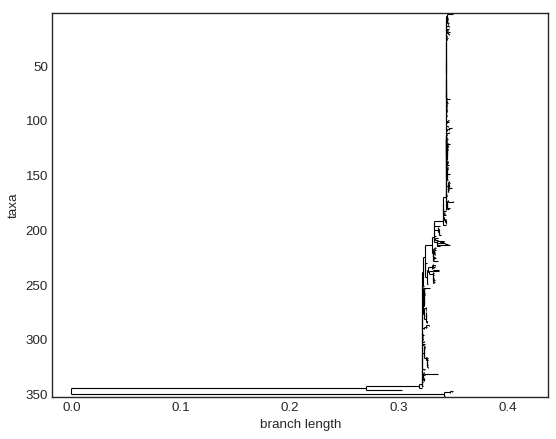

In [104]:
Phylo.draw(tree,  label_func=lambda x: '', do_show=False, show_confidence=False)

### Extract phylogenetic tree leaf names in order

In [113]:
def iterchildren(clade):
    for subclade in clade.clades:
        if subclade.is_terminal():
            yield subclade
            continue
        else:
            yield from iterchildren(subclade)

In [118]:
accessions_h1n1_msa = [x.split(maxsplit=1)[0] for x in headers]

In [119]:
tree_leaf_names = [x.name for x in iterchildren(tree.root)]

In [120]:
acc_to_seqarray = {x:y for x,y in zip(accessions_h1n1_msa, seq_arrays)}

In [121]:
seqarrays_tree_order = [acc_to_seqarray[x] for x in tree_leaf_names]

In [122]:
msa_array_null_tree_order = np.array(seqarrays_tree_order)

In [123]:
msa_array_null_tree_order = msa_array_null_tree_order.astype('float')
msa_array_null_tree_order[msa_array_null_tree_order == 45] = np.nan

### Extract flu_season and isolation_source values in tree order

In [137]:
df_flu_source = dfmd.loc[tree_leaf_names, ['flu_season', 'isolation_source']].copy()

In [142]:
flu_season_values = df_flu_source.flu_season.astype('category').values

Quick viz of flu season data

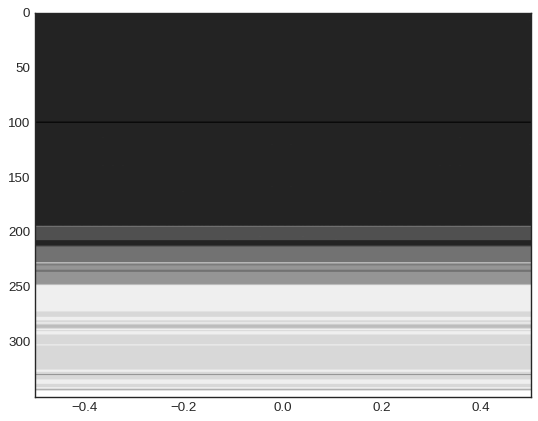

In [152]:
plt.imshow(np.transpose([flu_season_values.codes]), aspect='auto')

### Create Colormap and helper object for visualizing flu season in tree plot

Using ColorBrewer Set1 palette for highlighting flu season. 

In [164]:
from matplotlib.colors import Colormap

In [168]:
cmap_set1 = Colormap('Set1')

In [210]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

class MplColorHelper:
    def __init__(self, cmap_name, start_val, stop_val, alpha=1.0):
        self.cmap_name = cmap_name
        self.cmap = plt.get_cmap(cmap_name)
        self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
        self.alpha = alpha
        self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

    def get_rgba(self, val):
        r, g, b, _ = self.scalarMap.to_rgba(val)
        return (r,g,b,self.alpha)

In [214]:
cm_helper = MplColorHelper('Set1', 0, flu_season_values.codes.max(), alpha=0.5)

In [215]:
cm_helper.get_rgba(0)

(0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 0.5)

### Show custom flu season legend with colours

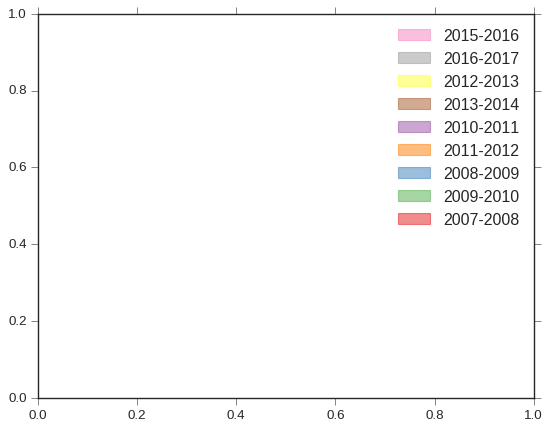

In [294]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

flu_code_to_season = {x:y for x,y in zip(flu_season_values.codes, flu_season_values.to_list())}
patches = [mpatches.Patch(color=cm_helper.get_rgba(code), label=season) for code, season in flu_code_to_season.items()]
plt.legend(handles=patches, bbox_to_anchor=(1,1))

plt.show()

### Tree + flu season + MSA plot

/home/CSCScience.ca/pkruczkiewicz/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


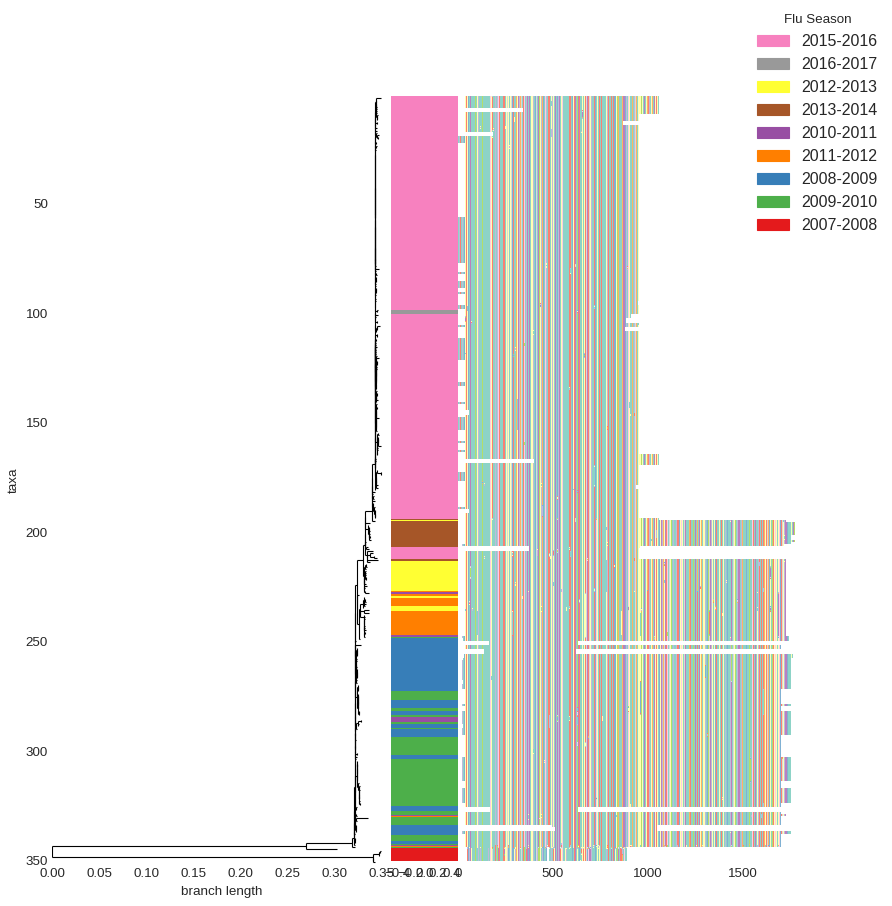

In [206]:
fig = plt.figure(figsize=(12,12))
ax1, ax_flu, ax2 = fig.subplots(1,3, sharey=True, gridspec_kw=dict(wspace=0, width_ratios=[5,1,5]))
plt.setp(ax2.spines.values(), linewidth=0)
plt.setp(ax1.spines.values(), linewidth=0)
plt.setp(ax_flu.spines.values(), linewidth=0)

Phylo.draw(tree, axes=ax1, label_func=lambda x: '', do_show=False, show_confidence=False)
ax1.set_xlim([0.0, 0.36])
ax2.imshow(msa_array_null_tree_order, cmap='Set3', aspect='auto',)

ax_flu.imshow(np.transpose([flu_season_values.codes]), aspect='auto', cmap='Set1')

fig.legend(handles=patches, title='Flu Season')

fig.show()

Max tree depth value

In [222]:
max(tree.depths().values())

0.35004029950000004

In [264]:
mplstyle.use(['seaborn-ticks'])

Visualize tree alone with gray ticks for branch length

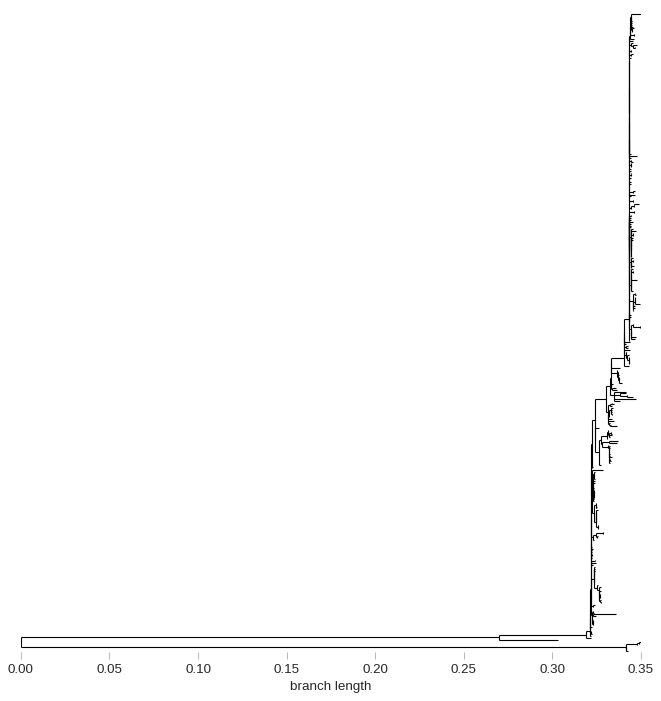

In [268]:
fig = plt.figure(figsize=(10,10))
ax = fig.subplots(1)
Phylo.draw(tree, 
           label_func=lambda x: '', 
           do_show=False,
           show_confidence=False, 
           axes=ax,)
ax.set_xlim([0.0, max(tree.depths().values())])
ax.get_yaxis().set_visible(False)
plt.setp(ax.spines.values(), linewidth=0)
plt.setp(ax.xaxis.get_ticklines(), linewidth=1, linestyle='-', color='gray')
ax.xaxis.tick_bottom()
plt.show()

### Tree + MSA with flu season overlay on tree

In [327]:
mplstyle.use('seaborn-ticks')

/home/CSCScience.ca/pkruczkiewicz/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


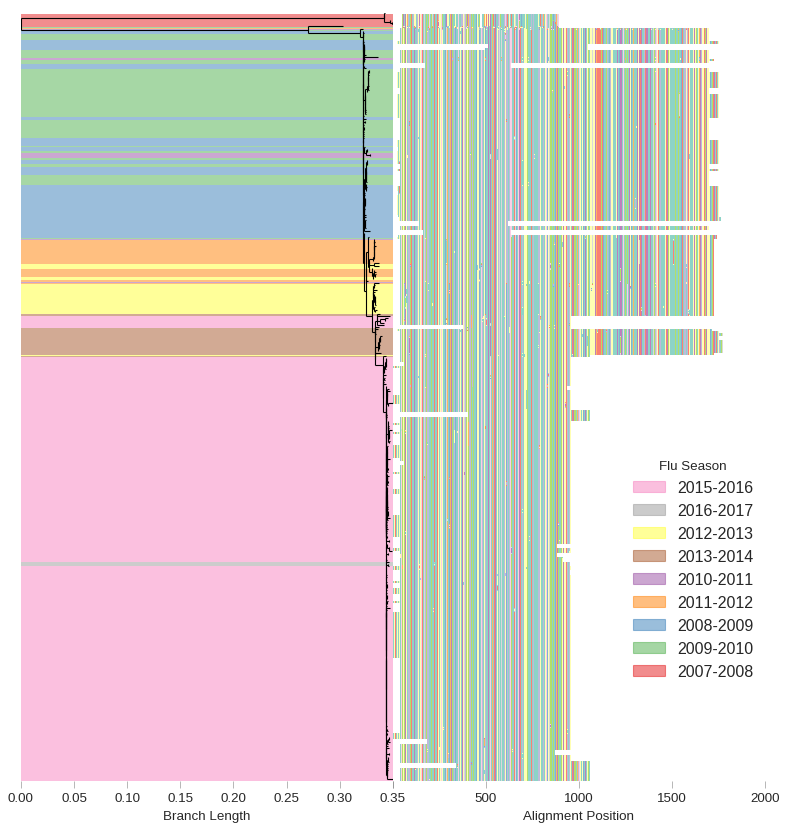

In [328]:
fig = plt.figure(figsize=(12,12), )
ax1, ax2 = fig.subplots(1,2,
                        sharey=True, 
                        gridspec_kw=dict(wspace=0, 
                                         width_ratios=[1,1]))
ax1.imshow(np.transpose([flu_season_values.codes]), aspect='auto', cmap='Set1', alpha=0.5)
Phylo.draw(tree, axes=ax1, label_func=lambda x: '', do_show=False, show_confidence=False)
ax1.set_xlabel('Branch Length')
plt.setp(ax1.spines.values(), linewidth=0)
plt.setp(ax1.xaxis.get_ticklines(), linewidth=1, linestyle='-', color='gray')
ax1.set_xlim([0.0, max(tree.depths().values())])
ax1.get_yaxis().set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.set_ylim([0,350])
ax2.imshow(msa_array_null_tree_order, cmap='Set3', aspect='auto')
ax2.set_xlabel('Alignment Position')
ax2.get_yaxis().set_visible(False)
plt.setp(ax2.xaxis.get_ticklines(), linewidth=1, linestyle='-', color='gray')
plt.setp(ax2.spines.values(), linewidth=0)
ax2.xaxis.set_ticks_position('bottom')
ax2.set_ylim([0,350])
plt.sca(ax2)
msa_tick_locs, msa_tick_labels = xticks()
locs = []
labels = []
for loc, label in zip(msa_tick_locs, msa_tick_labels):
    if loc < 0: continue
    props = label.properties()
    if loc == 0:
        label._text = ''
    else:
        label._text = str(int(loc))
    locs += [loc]
    labels += [label]
xticks(ticks=locs, labels=labels)
        
fig.legend(handles=patches, title='Flu Season', bbox_to_anchor=(.8,0.4))
# fig.suptitle('Maximum-likelihood phylogenetic tree of Ontario Human H1N1 HA sequences')
fig.show()

In [329]:
fig.savefig('phylogenetic-tree-H1N1-HA-gene-Ontario-Human-flu-season-MSA.pdf', bbox_inches='tight')

## Add MSA gap information to metadata table

- `gap_pos` - number of gap positions in MSA
- `start_gaps` - number of gap positions before first non-gap character
- `end_gaps` - number of gap positions after last non-gap character

In [336]:
dfmd_h1n1 = dfmd.loc[accessions_h1n1_msa,:]

In [341]:
dfmd_h1n1['gap_pos'] = [(acc_to_seqarray[x] == 45).sum() for x in accessions_h1n1_msa]

In [350]:
dfmd_h1n1['start_gaps'] = [(acc_to_seqarray[x] != 45).argmax() for x in accessions_h1n1_msa]
dfmd_h1n1['end_gaps'] = [(acc_to_seqarray[x][::-1] != 45).argmax() for x in accessions_h1n1_msa]

In [351]:
dfmd_h1n1.to_csv('HA-H1N1-human-ON.tsv', sep='\t', index=True)

# Interactive phylogenetic tree viz

Using a little Python CLI app called [shiptv](https://github.com/peterk87/shiptv), create an interactive HTML based phylogenetic tree viz that you can open in your browser.

Install `shiptv` with:

`pip install shiptv`


In [363]:
!shiptv --help

Usage: shiptv [OPTIONS]

  Create HTML tree visualization with metadata.

  The metadata for reference genomes can be extracted from the specified
  Genbank file.

  Any leaf names that are present in the tree but not present in the Genbank
  file are assumed to be user samples and are flagged as such in the
  metadata table as "user_sample"="Yes".

Options:
  -r, --ref-genomes-genbank FILE  Reference genome sequences Genbank file
  -n, --newick FILE               Phylogenetic tree Newick file  [required]
  -N, --output-newick PATH        Output Newick file
  -o, --output-html PATH          Output HTML tree path  [required]
  -m, --output-metadata-table PATH
                                  Output metadata table path  [required]
  --leaflist PATH                 Optional leaf names to select from
                                  phylogenetic tree for pruned tree
                                  visualization. One leaf name per line.
  --genbank-metadata-fields PATH  Optional fields 

In [364]:
!cat shiptv-COLUMNS

flu_season
strain
collection_date
note
isolation_source
gap_pos
start_gaps
end_gaps


In [366]:
!shiptv -n human-HA-sequences-by-flu-season/concat/mafft-msa/HA-H1N1-all-seasons.fa.treefile \
 -r 2019-09-26-McLaughlin-NCBI-Influenza-DB-H3-or-H1-Ontario-metadata-from-genbank.gb \
 -N out.newick -o shiptv.html -m out.tab --metadata-fields-in-order shiptv-COLUMNS \
 --user-sample-metadata HA-H1N1-human-ON.tsv -C 95

2019-10-04 11:51:25,572 INFO: Collapsing internal branches with support values less than 95.0 [in cli.py:88]
2019-10-04 11:51:26,251 INFO: Parsed metadata from "2019-09-26-McLaughlin-NCBI-Influenza-DB-H3-or-H1-Ontario-metadata-from-genbank.gb" with columns "organism;mol_type;strain;serotype;db_xref;country;host;segment;collection_date;isolation_source;isolate;note;lab_host;lat_lon [in cli.py:95]
2019-10-04 11:51:26,252 INFO: Stripped internal whitespace from serotype metadata field [in shiptv.py:168]
2019-10-04 11:51:26,257 INFO: Split country metadata field into country and region on ":" [in shiptv.py:174]
2019-10-04 11:51:26,311 INFO: Normalized collection_date metadata field to ISO date format and extracted year integer into collection_year field [in shiptv.py:180]
/home/CSCScience.ca/pkruczkiewicz/miniconda3/lib/python3.7/site-packages/shiptv/shiptv.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio